## データの読込

In [1]:
import pandas as pd
df = pd.read_csv("vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


In [2]:
import os
import time
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from natsort import natsorted 

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

import warnings
warnings.simplefilter('ignore')

In [3]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [4]:
### パイプライン

# 数値データカラム名を取得
number_columns = df.select_dtypes(include="number").columns
number_columns = list(number_columns)

# カテゴリデータカラム名を取得
category_columns = df.select_dtypes(include="object").columns
category_columns = list(category_columns)

# 数値データ用の変換
numeric_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
)

# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping = []

for column in df.select_dtypes(include="object"):
    ordinal_one_cols_mapping = []
    for category in natsorted(df[column].unique()):
        ordinal_one_cols_mapping.append(category)

    ordinal_all_cols_mapping.append(ordinal_one_cols_mapping)


# カテゴリー数が少ないカテゴリーデータ用の変換
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(
                handle_unknown = 'use_encoded_value', # 未知数をunknown valueに置き換える設定
                unknown_value = -1,
                categories = ordinal_all_cols_mapping
            )
        )
    ]
)

# ColumnTransformerの作成
columns_transformers = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, number_columns),
        ('category', categorical_transformer, category_columns),
    ]
)

# カラム変換用のパイプラインの作成
transformer = Pipeline(
    [
        ("columns_transformers", columns_transformers),
    ]
)

In [5]:
df_tf = transformer.fit_transform(df)

all_columns = df.columns.tolist()
all_columns.remove("VGChartz_Score")

df_tf = pd.DataFrame(
    df_tf,
    columns = all_columns
)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df_tf.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df_tf.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [7]:
alpha_lasso = []
coef_list = []
intercept_list = []
train_score = []
test_score = []

## 探索範囲

In [8]:
lasso_1 = np.linspace(0.01,100,1000)

## 学習

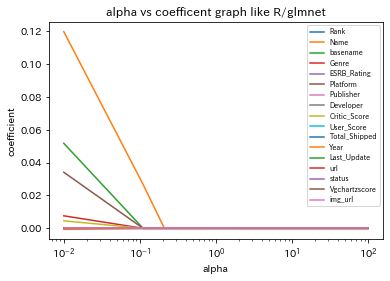

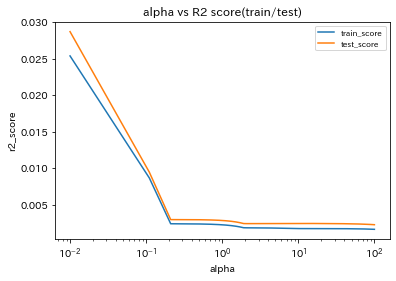

In [9]:
for i in lasso_1:

    model = Lasso(
                    alpha = i, 
                    max_iter=10000, 
                    random_state=SEED
                    )

    # 学習
    model.fit(X_train,y_train)

    # 推論
    pre_train = model.predict(X_train)
    pre_test = model.predict(X_test)

    # スコアの集約
    alpha_lasso.append(i)
    coef_list.append(model.coef_) # 回帰係数
    intercept_list.append(model.intercept_) # 切片
    train_score.append(model.score(X_train, y_train))
    test_score.append(model.score(X_test, y_test)) # テストデータに対するR2スコア

# DataFrame、Series 化
df_count = pd.Series(alpha_lasso,name = 'alpha') # 正則化の強さ
df_coef= pd.DataFrame(coef_list, columns = X_train.columns) # 回帰係数
df_inter = pd.Series(intercept_list,name = 'intercept') # 切片
df_train_score = pd.Series(train_score,name = 'train_score') # 学習データに対するスコア
df_test_score = pd.Series(test_score,name = 'test_score') # テストデータに対するスコア

# alphaと回帰係数の可視化
plt.title('alpha vs coefficent graph like R/glmnet')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.plot(df_count,df_coef)
plt.legend(labels = df_coef.columns,loc='uper right',fontsize=7)
plt.show()

# alphaとR2スコアのグラフ
df_score = pd.concat([df_train_score,df_test_score], axis=1)
plt.title('alpha vs R2 score(train/test)')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('r2_score')
plt.plot(df_count,df_score)
plt.legend(labels = df_score.columns,loc='uper right',fontsize=8)
plt.show()

## シンプルな推論

In [10]:
model = Lasso(
            alpha = 0.1, 
            max_iter=10000, 
            random_state=SEED
            )

# 学習
model.fit(X_train, y_train)

# 推論
y_pred = model.predict(X_test)

# 評価
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE", rmse)

RMSE 0.9313807445033818


## GroupKFold で学習・推論

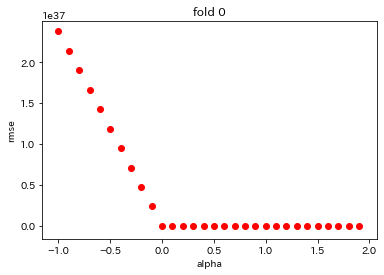

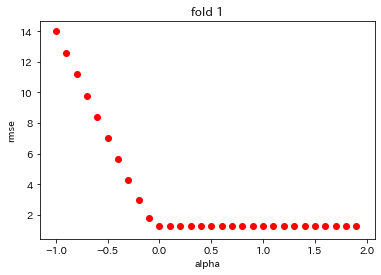

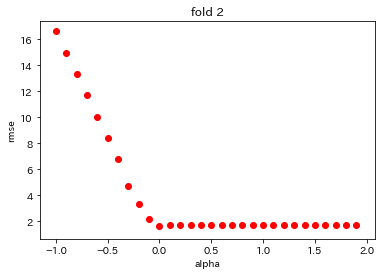

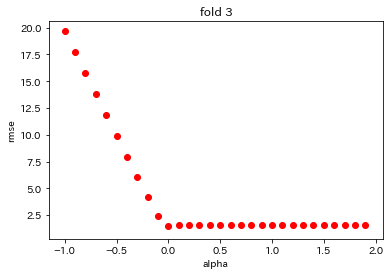

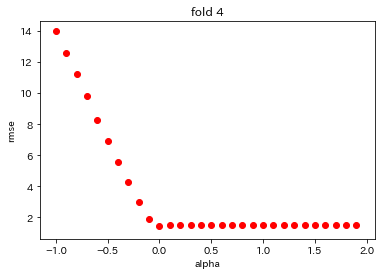

In [11]:
gkf = GroupKFold(n_splits=5)

groups = X_train["Genre"]

for i, (train_index, test_index) in enumerate(gkf.split(X_train, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 探索
    for alpha in range(-10, 20, 1):

        model = Lasso(
                    alpha = alpha/10 , 
                    max_iter=10000,
                    random_state=SEED
                    )

        # 学習
        model.fit(X_train_gkf, y_train_gkf)

        # 推論
        y_pred = model.predict(X_test_gkf)

        # 評価
        rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
        
        # 可視化
        plt.scatter(
            alpha/10, 
            rmse,
            color="red"
            )
        
    plt.title(f"fold {i}")
    plt.xlabel('alpha')
    plt.ylabel('rmse')
    plt.show()

## LassoCV

In [12]:
model = LassoCV(
            alphas=[0.01, -1, 2], 
            cv = 5, 
            max_iter=100000,
            random_state=SEED
            )

# 学習
model.fit(X_train, y_train)

# ベストスコア
print("Best alpha:", model.alpha_)
print("重み:", model.coef_)
print("切片:", model.intercept_)

# ベストスコア(alpha)を設定
best_model = Lasso(
                alpha=model.alpha_,
                max_iter=100000,
                random_state=SEED
                )

# ベストスコアで学習
best_model.fit(X_train, y_train)

# ベストスコアのモデルで推論
y_pred = best_model.predict(X_test)

# 評価
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE", rmse)

Best alpha: 0.01
重み: [-0.00000000e+00  1.19582956e-01  5.16855133e-02  7.60801569e-03
  0.00000000e+00  3.40944575e-02  0.00000000e+00  0.00000000e+00
  4.57007862e-03 -0.00000000e+00  0.00000000e+00 -6.01479616e-04
 -1.33607435e-05  3.14296420e-07  3.51993675e-04 -1.63156663e-06
  6.92296310e-07]
切片: -0.05693081814503002
RMSE 0.9232324622403981
